# Modelling 01

In this notebook I will explore different predictive models.  
First, I will create a baseline model by calculating the average of pickups per zone and per hour.  
After that, I will use some regression models to compare with the baseline model and select the best one.

### 0. [Create helper functions](#Create-helper-functions)
- [``split_data()``](#split_data())
- [``plot_real_vs_pred()``](#plot_real_vs_pred()): bar plot to visually compare real vs predicted values.
- [``get_metrics()``](#get_metrics()): it calculates relevant metrics all at once.
- [``compare_model_metrics()``](#compare_model_metrics()): bar plot to compare metrics from different models and choose the best one.

### 1. [Import dataset and select features](#Import-dataset-and-select-features)

- [Select columns of interest](#Select-columns-of-interest)
- [Separate Input and Output variables](#Separate-Input-and-Output-variables)

### 2. [Split data](#Split-data)

### 3. [Models](#Models)

- [Linear Regression](#Linear-Regression)
- [K Nearest Neighbour Regressor (KNN)](#K-Nearest-Neighbour-Regressor-(KNN))

NOTE: Create base model. It will give us the baseline accuracy and and I should try to beat this baseline accuracy using more advanced techniques. This base model could be the average for a specific hour.

# Create helper functions

### ``split_data()``
This function will use ``sklearn.model_selection.train_test_split`` to split the data into:
- Train: 60%
- Validation: 20% (to validate training)
- Test: 20% (to validate the model)

In [14]:
def split_data(X,y):
    valSize = 0.25 #0.8 * 0.2 = 0.2
    testSize = 0.2

    # Split TRAIN-TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Split TRAIN-VALIDATION
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valSize, random_state=1)
    
    
    print('X_train: {0} ({1}%)'.format(X_train.shape[0], (X_train.shape[0]/X.shape[0])*100))
    print('y_train: {0} ({1}%)'.format(y_train.shape[0], (y_train.shape[0]/X.shape[0])*100))

    print('X_val: {0} ({1}%)'.format(X_val.shape[0], (X_val.shape[0]/X.shape[0])*100))
    print('y_val: {0} ({1}%)'.format(y_val.shape[0], (y_val.shape[0]/X.shape[0])*100))

    print('X_test: {0} ({1}%)'.format(X_test.shape[0], (X_test.shape[0]/X.shape[0])*100))
    print('y_test: {0} ({1}%)'.format(y_test.shape[0], (y_test.shape[0]/X.shape[0])*100))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### ``plot_real_vs_pred()``

This functions creates a bar plot to visually compare real vs predicted values.  

Inputs:
    - Model name
    - 'y' real values
    - 'y' predected values
Output:
    - Bar plot

In [2]:
def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

### ``get_metrics()``

Function to calculate relevant metrics all at once.  

Inputs:
    - Model name
    - Real target values
    - Predected values
Outputs:
    - Model name
    - MAE
    - RMSE
    - R2
    - R (correlation)

In [3]:
def get_metrics(model_name, y_real, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # MAE: same units as target variable. It is more robust to outliers
    MAE = mean_absolute_error(y_real, y_pred)

    # RMSE: same units as target variable
    RMSE = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R^2
    R2 = r2_score(y_real, y_pred)
    
    # Correlation
    R = np.corrcoef(y_real, y_pred)[0][1]
    
    print('MODEL: ', model_name)
    print('MAE: ', MAE)
    print('RMSE: ', RMSE)
    print('R^2 (Coefficient of determination): ', R2)
    print('R (Correlation coefficient): ', R)
    
    return model_name, MAE, RMSE, R2, R

### ``compare_model_metrics()``

Given a list of ``'model_metrics'``, obtained with the function ``get_metrics()``, this function creates several bar plots to compare metrics from different models and choose the best one.

In [4]:
def compare_model_metrics(mod_metric_list):
    
    plt.style.use('ggplot')
    # create DataFrames with metric data
    df_MAE = pd.DataFrame(columns=['MAE'])
    df_MAE_index = []
    df_RMSE = pd.DataFrame(columns=['RMSE'])
    df_RMSE_index = []
    df_R2 = pd.DataFrame(columns=['R2'])
    df_R2_index = []
    df_R = pd.DataFrame(columns=['R (Correlation)'])
    df_R_index = []
    
    for mod in mod_metric_list:
        
        df_MAE = df_MAE.append({'MAE': mod[1]}, ignore_index=True)
        df_MAE_index.append(mod[0])
        df_RMSE = df_RMSE.append({'RMSE': mod[2]}, ignore_index=True)
        df_RMSE_index.append(mod[0])
        df_R2 = df_R2.append({'R2': mod[3]}, ignore_index=True)
        df_R2_index.append(mod[0])
        df_R = df_R.append({'R (Correlation)': mod[4]}, ignore_index=True)
        df_R_index.append(mod[0])
    
    # set index names so they appear y the bar plot
    df_MAE.index = df_MAE_index
    df_RMSE.index = df_RMSE_index
    df_R2.index = df_R2_index
    df_R.index = df_R_index
    
    # sort values so the best model appears in firsst position
    df_MAE = df_MAE.sort_values('MAE', ascending=False)
    df_RMSE = df_RMSE.sort_values('RMSE', ascending=False)
    df_R2 = df_R2.sort_values('R2', ascending=True)
    df_R = df_R.sort_values('R (Correlation)', ascending=True)
    
    # create figure and one axis per metric
    f = plt.figure(figsize=(8,len(mod_metric_list*3)))
    axes1 = f.add_subplot(4,1,1)
    axes2 = f.add_subplot(4,1,2)
    axes3 = f.add_subplot(4,1,3)
    axes4 = f.add_subplot(4,1,4)
    
    # plot dataframes with DataFrame.plot()
    df_MAE.plot(kind='barh',ax=axes1, title = 'Compare Model Metrics', color='lightcoral')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_RMSE.plot(kind='barh', ax=axes2, color='cornflowerblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_R2.plot(kind='barh', ax=axes3, color='goldenrod')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_R.plot(kind='barh', ax=axes4, color='mediumseagreen')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    
    # annotate bars with result values 
    for p in axes1.patches:
        axes1.annotate(np.round(a=p.get_width(), decimals=0), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes2.patches:
        axes2.annotate(np.round(a=p.get_width(), decimals=0), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
    for p in axes3.patches:
        axes3.annotate(np.round(a=p.get_width(), decimals=2), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes4.patches:
        axes4.annotate(np.round(a=p.get_width(), decimals=2), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
        
    plt.show()

# Import dataset and select features

From the cleaned datasets saved from previous notebooks, I will use the one from ``2019`` and will leave the others (``2018`` and ``2017``) in case I need more training data.

In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Select columns of interest

According to the conclusion from the notebook ``Data_Analysis_01.ipynb``, I will use the following columns:

- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``
- ``pickups``

In [6]:
# Import dataset
df = pd.read_csv('../data/Data_Cleaned_2019_To_Model.csv', sep=',',                 
                 dtype = {"LocationID" : "object"},
                 parse_dates=['datetime'])

# Select columns of interest
df = df[['month', 'hour', 'week', 'dayofweek', 'isholiday', 'LocationID', 'precipitation', 'pickups']]
df.info() # check dtypes
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586920 entries, 0 to 586919
Data columns (total 8 columns):
month            586920 non-null int64
hour             586920 non-null int64
week             586920 non-null int64
dayofweek        586920 non-null int64
isholiday        586920 non-null int64
LocationID       586920 non-null object
precipitation    586920 non-null float64
pickups          586920 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 35.8+ MB


,month,hour,week,dayofweek,isholiday,LocationID,precipitation,pickups
0,1,0,1,1,1,4,0.13,49.0
1,1,0,1,1,1,12,0.13,4.0
2,1,0,1,1,1,13,0.13,64.0
3,1,0,1,1,1,24,0.13,53.0
4,1,0,1,1,1,41,0.13,82.0


### Separate Input and Output variables

**INPUT variables**: (must be Pandas DataFrame)
- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``

**OUTPUT variable**: (must Pandas Series)
- ``pickups``

In [7]:
# Separate variables
X = df[['month','hour','week','dayofweek','isholiday','LocationID','precipitation']]
y = df['pickups']
print("FEATURES 'X' should be a Pandas DataFrame: ", type(X)) # 'X' must be DataFrame and 'y' must be a Pandas Series
display(X.head(2))
print("TARGET VARIABLE 'y' should be a Pandas Series: ",type(y))
display(y.head(2))

FEATURES 'X' should be a Pandas DataFrame:  <class 'pandas.core.frame.DataFrame'>


,month,hour,week,dayofweek,isholiday,LocationID,precipitation
0,1,0,1,1,1,4,0.13
1,1,0,1,1,1,12,0.13


TARGET VARIABLE 'y' should be a Pandas Series:  <class 'pandas.core.series.Series'>


0    49.0
1     4.0
Name: pickups, dtype: float64

# Split data

Using the custom function ``split_data()`` I get the **training**, **validation** and **test** data.

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

X_train: 352152 (60.0%)
y_train: 352152 (60.0%)
X_val: 117384 (20.0%)
y_val: 117384 (20.0%)
X_test: 117384 (20.0%)
y_test: 117384 (20.0%)


# Models

As the output variable is a number we need to solve a **regression** problem.

I will start with:
- **Linear Regression**
- **K Nearest Neighbour Regressor**
- **Decision Tree Regressor**

### Baseline model: average of pickups per zone, per hour

I will use this baseline model to compare the results with the regression models.

In [ ]:
df.head(100)

In [ ]:
basemodel = df.groupby(['hour', 'LocationID']).sum()
basemodel.sort_index()
basemodel.head(100)

date time object into unix-tipe format

In [ ]:
df.info()

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Create an instance of the model and train it
reg = LinearRegression()
reg.fit(X_train, y_train)

# Do predictions
reg_y_pred = reg.predict(X_val)

#### Get metrics and plot Real vs Predicted values

I can see with the graph that predictions are quite bad.

Metrics confirm this. There is a weak correlation (0.33) between real values and predictions and errors of 110-150 (MAE-RMSE) are not good enough for the scale of the pickups variable.

MODEL:  Linear Regression
MAE:  110.11816891188789
RMSE:  150.91705611228386
R^2 (Coefficient of determination):  0.1092576219241913
R (Correlation coefficient):  0.33076886258728294


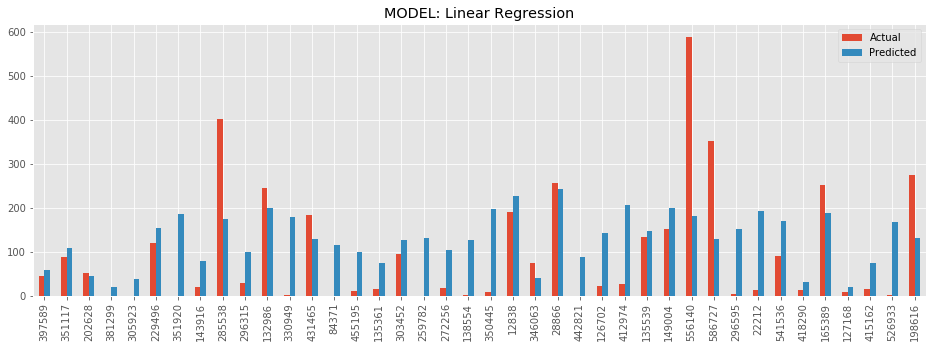

In [23]:
reg_metrics = get_metrics('Linear Regression',y_val, reg_y_pred)
plot_real_vs_pred('Linear Regression', y_val, reg_y_pred)

### K Nearest Neighbour Regressor (KNN)

After a couple of iterations (trial and error) these are the parameters I found best:

- ``k = 2``  
- ``weights = 'uniform'``

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Create an instance.
regk = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')

# Train the data
regk.fit(X_train, y_train)

# Do predictions
regk_y_pred = regk.predict(X_val)

#### Get metrics and plot Real vs Predicted values

There is a significant improvement with KNN. It is even noticeable in the bar plot where 'Actual' and 'Preedicted' are more similar.  
``R2`` and ``R`` show a strong correlation between real values and predicted ones.
Also, and error of 26 (``MAE``) or 50 (``RMSE``) it is relatively not that bad. In zones with and average of 300 pickups per hour may give us good predictions but in other zones with just 10-20 pickups per hour, the prediction may differ a lot from the reality.

**Conclusion**: I am happy with ``R2`` and ``R`` values. In the next models I will try to lower ``MAE`` and ``RMSE``.

MODEL:  KNN
MAE:  26.965242281741975
RMSE:  50.84534576960667
R^2 (Coefficient of determination):  0.8988937797534982
R (Correlation coefficient):  0.9484065103130591


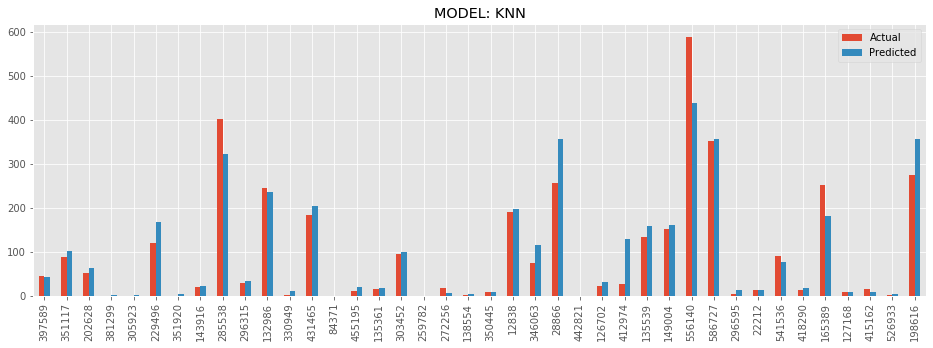

In [21]:
regk_metrics = get_metrics('KNN',y_val, regk_y_pred)
plot_real_vs_pred('KNN', y_val, regk_y_pred)

### Decision Tree Regressor

After a couple of iterations (trial and error) these are the parameters I found best:

``max_depth`` (number of splits): ``20``  
``min_samples_leaf`` (minimum number of samples for each split group): ``15``

It seems that if I increase those values the model does not improve.

In [25]:
from sklearn.tree import DecisionTreeRegressor

# Create an instance.
regd = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf=15)

# Train the data
regd.fit(X_train, y_train)

# Do predictions
regd_y_pred = regd.predict(X_val)

#### Get metrics and plot Real vs Predicted values

There is a bit of improvement in comparison with the KNN model.  
It is not noticable in the bar plot but the metrics are better.

MODEL:  Decision Tree
MAE:  18.31967946384341
RMSE:  36.54874516596225
R^2 (Coefficient of determination):  0.9477579264109853
R (Correlation coefficient):  0.9735426284154586


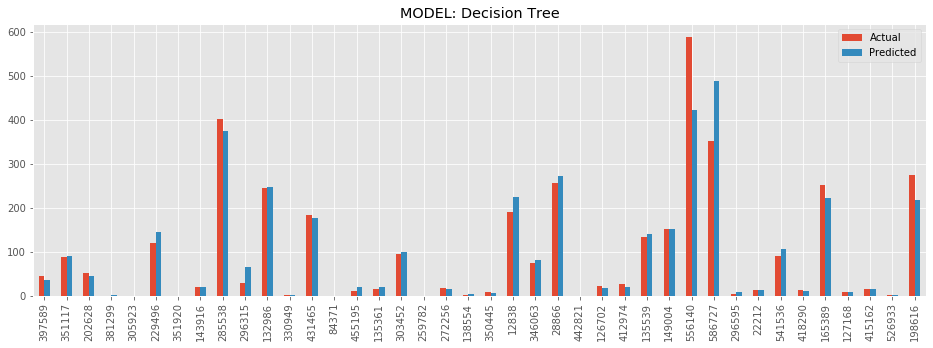

In [31]:
regd_metrics = get_metrics('Decision Tree', y_val, regd_y_pred)
plot_real_vs_pred('Decision Tree', y_val, regd_y_pred)

### Compare metrics

**Linear Regression** is the worst model, far away from the other two.  
**Decision Tree** beats **KNN** for a small but relevant amount.

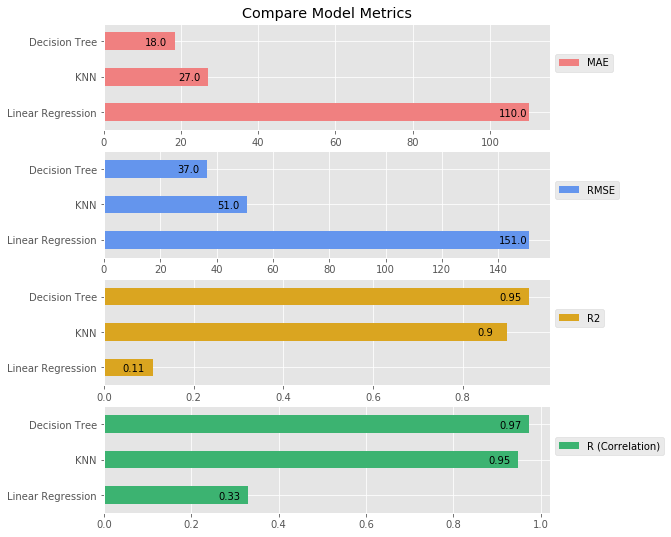

In [28]:
compare_model_metrics([reg_metrics, regk_metrics, regd_metrics])

# Second approach: using GridSearchCV

I will not try to improve LinearRegression as their results are very bad and far from KNN and Decision Trees

### K Nearest Neighbour Regressor_GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

regk_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid={"n_neighbors":np.arange(2,5)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regk_grid.fit(X_train,y_train)

# Do predictions
regk_grid_y_pred = regk_grid.predict(X_val)
%time

In [ ]:
regk_grid_metrics = get_metrics('KNN_Grid', y_val, regk_grid_y_pred)
plot_real_vs_pred('KNN_Grid', y_val, regk_grid_y_pred)

In [ ]:
visualize_metrics(regd_metrics, regk_metrics, regk_grid_metrics)

# REPASAR FUNCIÓN DE VISUALIZACIÓN, ALGO NO ESTÁ BIEN

## MAE

Measures average magnitud of the errors without considering their direction (all errors in absolute value). It is intuitive to calculate, but you lose information related to the magnitud of the error.<br>
Units are the same as the target variable.<br>
Value range from 0 to infinite. Lower values are better.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Use against predictions
MAE = mean_absolute_error(reg.predict(X_val), y_val)
MAE

## MAPE

Similar to MAE but it measures the error in percentage.<br>
Lower values are better.<br>
MAPE is not in sklearn so I calculate it MANUALLY with pandas:

In [ ]:
MAPE = np.mean(np.abs(reg.predict(X_val) - y_val)/y_val)
MAPE

## RMSE

Measures average magnitud of errors.<br>
Units are the same as the target variable.<br>
Value range from 0 to infinite. Lower values are better.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Use against predictions (we have to calculate the squared root of MSE)
RMSE = np.sqrt(mean_absolute_error(reg.predict(X_val), y_val))
RMSE

In [ ]:
print('MEAN: ', y_val.mean())
print('MEDIAN: ', y_val.median())
print('MAE: ', MAE)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)

## Correlation

**There should be a strong correlation between predictions and real values.<br>
However, I get a very week correlation value of 0.31**

In [ ]:
np.corrcoef(reg.predict(X_val), y_val)[0][1]

## Bias
It is the average of errors (prediction values minus real values).<br>
Negative errors will compensate positive ones.

In [ ]:
bias = np.mean(reg.predict(X_val) - y_val)
bias

## Variance
Is the average of errors in predictions between two different data sets.

In [ ]:
# create table from X_train with same number of rows as X_val
# so it can be used to calculate the variance
X_train_for_variance = X_train.head(X_val.shape[0])

variance = np.mean(reg.predict(X_train_for_variance) - reg.predict(X_val))
variance

In [ ]:
# Merge X_train with predictions
combine = X_train.copy()
combine['pickups'] = y_train
combine['pickups Prediction'] = reg.predict(X_train)

combine.head(100)

In [ ]:
# Merge X_test with predictions
combine2 = X_test.copy()
combine2['pickups'] = y_test
combine2['pickups Prediction'] = reg.predict(X_test)

combine2.head(100)

In [ ]:
predictions = reg.predict(X_test)
X_test_g = X_test.groupby(['month', 'day','hour','LocationID']).sum()
X_test_g.head(100)

## Pack model with Pickle

In [ ]:
import pickle
pickle.dump(reg,open('./model_reg_01.pickle','wb'))